# Wycena Monte Carlo

In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
import dash_table

from dash.dependencies import Input, Output,State
from jupyter_dash import JupyterDash

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import calendar

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

import yfinance as yf
import quandl
quandl.ApiConfig.api_key = "Tu kod API"

## 1. Symulacja realizacji Geometrycznego Ruchu Browna

Poniższa funkcja symuluje GBM przy zadanych parametrach. Możliwe jest również symulowanie par antytetycznych trajektorii, dla późniejszej redukcji błędu wyceny. 

In [2]:
def generateGBM(S0, mu, sigma, T, n_steps, n_paths, antithetic = False, plot_= True):
    
    # For variance reduction when pricing options
    if antithetic:
        
        n_paths = int((n_paths-n_paths%2)/2) # == *0.5 and round down
        
        dt = T / n_steps
        paths = np.zeros((n_steps+1 , n_paths))
        paths[0] = S0
        
        
        paths_a = np.zeros((n_steps+1, n_paths))   
        paths_a[0] = S0
        
        for t in range(1, n_steps+1):
            norm_inc = np.random.normal(0,1,n_paths)
            paths[t] = paths[t - 1] * np.exp((mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*norm_inc)
            paths_a[t] = paths[t - 1] * np.exp((mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*(-norm_inc))

        if plot_:
            plt.plot(paths, color = 'b', label = 'GBM')
            plt.plot(paths_a, color='r', label = 'Antithetic')
        return paths, paths_a
    
    #Standard GBM generation
    else:
        dt = T / n_steps
        paths = np.zeros((n_steps+1 , n_paths))
        paths[0] = S0
        
        for t in range(1, n_steps+1):
            norm_inc = np.random.normal(0,1,n_paths)
            paths[t] = paths[t - 1] * np.exp((mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*norm_inc)
            
        if plot_:
            plt.plot(paths)
            
        return paths

Przykładowe wywołanie funkcji:

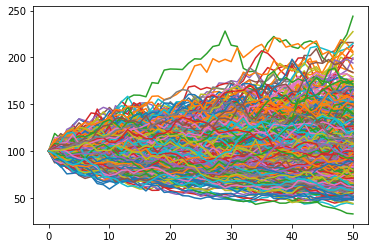

In [3]:
paths = generateGBM(S0 = 100,
                    mu = 0.03,
                    sigma = 0.3,
                    T = 1,
                    n_steps = 50,
                    n_paths = 1000,
                    antithetic = False,
                    plot_ = True)

## 2. Model Rynku, Akcji i Opcji

Zaimplementujemy klasy: Market, Stock i Option, które ułatwią nam później kalibrację modeli do danych rzeczywistych.

### Market
- klasa zaciągać będzie z Quandla zwroty na amerykańskich rządowych obligacjach i interpolować je na zadaną datę
- wyliczony T-Bill yield będziemy traktować jako stopę wolną od ryzyka

In [4]:
class Market:
    
    def __init__(self):

        today = datetime.today().date()
        TBill_yields = quandl.get("USTREASURY/YIELD",
                                  start_date = str(today - timedelta(10)),
                                  end_date = str(today))
        
        self.yieldCurve = self.parse_yield_df(TBill_yields)

    def __str__(self):
        repr_str = """
        US TBill yields:
        ================
        {}
        """.format(str(self.yieldCurve))
        return repr_str
        
        
    def parse_yield_df(self, df):
                
        df = df.tail(1).transpose()
        maturities = df.index
        as_of = df.columns[0].date()
        matu_dict = {'MO' : relativedelta(months = +1),
                     'YR' : relativedelta(years = +1)}

        matu_parsed = [as_of + int(m.split(' ')[0]) * matu_dict[m.split(' ')[1]] for m in maturities]
        df.index = matu_parsed
        return df
    
        
    def fetch_r(self, T):
        
        T = datetime.strptime(T,"%Y-%m-%d")
        x_timestamps = [self.toTimestamp(matu) for matu in self.yieldCurve.index.values]
        
        yield_interp = np.interp(self.toTimestamp(T),
                                 np.array(x_timestamps),
                                 self.yieldCurve.values.flatten())
        return yield_interp/100

    def toTimestamp(self,t):
        return calendar.timegm(t.timetuple())


In [5]:
mkt = Market()
print(mkt)


        US TBill yields:
        Date        2021-05-28
2021-06-28        0.01
2021-07-28        0.01
2021-08-28        0.01
2021-11-28        0.03
2022-05-28        0.05
2023-05-28        0.14
2024-05-28        0.30
2026-05-28        0.79
2028-05-28        1.24
2031-05-28        1.58
2041-05-28        2.18
2051-05-28        2.26
        


### Stock:
- klasę inicjujemy szeregiem czasowym cen akcji
- pozwala na kalibrację parametrów GBM i odczytywanie $\mu$, $\sigma$, $S_0$, $S_t$

In [6]:
class Stock:
    
    def __init__(self, PriceTS):
        
        self.ticker = PriceTS.name
        self.S = PriceTS
        self.S0 = PriceTS[-1]
        self.calibration(PriceTS)
        
    def calibration(self, PriceTS):
        
        logreturns = np.log(PriceTS).diff().dropna()
        sig = np.sqrt(np.mean(np.power(logreturns,2)))*np.sqrt(365)   
        mu = (np.mean(logreturns) + 0.5 * (sig**2) / 365)*365

        self.mu, self.sigma = mu, sig
        
    def __str__(self):
        repr_str = """
        {} stock:
        ==========
        S0  :{:.2f}
        mu  :{:.4f}
        sig :{:.4f}""".format(self.ticker, self.S0, self.mu, self.sigma)
        return repr_str

In [7]:
start_date = "2020-04-24"
end_date = '2021-04-24'

ticker = "GOOG"
df = yf.download(ticker, start_date, end_date)['Adj Close']
df.name = ticker

stock = Stock(df)    

print(stock)

[*********************100%***********************]  1 of 1 completed

        GOOG stock:
        S0  :2315.30
        mu  :0.9260
        sig :0.3559


### Option
- ta klasa reprezentuje **europejską** opcję
- należy przy inicjacji zadać jej nazwę oraz funkcję wypłaty poprzez anonimową funkcję
- pozwala metodą MC wyliczać cenę, deltę opcji, oraz błędy ich estymacji (standard error)
- pozwala 'nadpisywać' parametry, jeśli chcemy wycenić ten sam rodzaj opcji, ale np. z innym strike, czy inną barierą

In [8]:
class Option:
    
    def __init__(self, name, K, T, Payoff_Fn, Barrier = np.nan):
        self.K = K
        self.T = T
        self.name = name
        self.Payoff = Payoff_Fn
        self.B = Barrier
        self.ExpiryDate = lambda T = T: (datetime.today().date() + relativedelta(days=+365*T)).strftime("%Y-%m-%d")
        
    def __str__(self):
        return self.name
        
    def PriceByMC(self, Market, Underlying, 
                  n_steps, MC_repetitions, 
                  antithetic = True, epsilon = 0.001,
                  overrides = {}):

        # Inicjalizuj z oryginalnymi parametrami
        params = {'S0': Underlying.S0,
                  'r' : Market.fetch_r(self.ExpiryDate()),
                  'sigma' : Underlying.sigma,
                  'T' : self.T,
                  'K': self.K,
                  'B': self.B}
        
        # Nadpisz wybrane z nich
        for ov in overrides: params[ov] = overrides[ov]
        
        disc_factor = np.exp(-params['r']*params['T'])
                
        # Symuluj GBM
        ST_all = generateGBM(S0 = params['S0'],
                             mu = params['r'],
                             sigma = params['sigma'],
                             T = params['T'],
                             n_steps = n_steps,
                             n_paths = MC_repetitions, 
                             antithetic= antithetic,
                             plot_ = False)
        
        # antithetic=True da listę [S, S_anti]
        # wymuszamy też listę w przypadku antithetic=False,
        # żeby niżej program był jednolity
        if not antithetic: 
            ST_all = [ST_all]
            
        

        Payoffs = []
        Deltas = []
        
        # iteracja po dwóch wersjach ścieżek: i=1,2 dla [S, S_anti], albo tylko po i=1, dla [S]
        for i, S in enumerate(ST_all):
            Payoff = self.Payoff(S, params['K'], params['B'])
            
            # estymacja Delty:
            S0 = params['S0']
            dS = S0*epsilon
            
            Payoff_minus = self.Payoff(S*(S0-dS)/S0, params['K'], params['B'])
            Payoff_plus  = self.Payoff(S*(S0+dS)/S0, params['K'],  params['B']) 
            
            Delta = disc_factor*(Payoff_plus - Payoff_minus)/(2*epsilon*S0) 
            
            Payoffs.append(Payoff)
            Deltas.append(Delta)

        # antytetyczne uśredniamy po wersjach
        if antithetic:
            P, P_anti = Payoffs[0], Payoffs[1]
            D, D_anti = Deltas[0], Deltas[1]
            
            Payoffs = (P + P_anti)/2
            Deltas  = (D + D_anti)/2
            
        else:
            Payoffs = Payoffs[0]
            Deltas = Deltas[0]
        
        N = MC_repetitions

        # Estymacja błędów:
        Price = (Payoffs*disc_factor).mean()
        Price_se = np.sqrt(((Payoffs*disc_factor-Price)**2).sum()/(N*(N-1)))
        
        self.Price = Price
        self.Price_se = Price_se
        
        # Delta approximation:
        Delta = Deltas.mean()
        Delta_se = np.sqrt(((Deltas-Delta)**2).sum()/(N*(N-1)))
        
        self.Delta = Delta
        self.Delta_se = Delta_se
        return Price
         
    def plot_weighted_realizations(self, Market, Underlying,
                                   n_steps= 50, MC_repetitions= 1000):
        
        paths = generateGBM(S0 = Underlying.S0,
                    mu = Market.fetch_r(self.ExpiryDate()),
                    sigma = Underlying.sigma,
                    T = self.T,
                    n_steps = n_steps,
                    n_paths = MC_repetitions,
                    antithetic = False,
                    plot_ = False)
        H = self.Payoff(paths, self.K, self.B)
        if H.max()!=0:
            w = H/H.max()
        else:
            w = 0*H
        
        for i, a in enumerate(w):
            _= plt.plot(paths[:,i], alpha = a)

Poniżej przykładowe definicje opcji. Te zadeklarowane w liście `option_list` będą do wyboru później w programie - więc można dopisać sobie więcej. Parametry jak strike, czy barrier nie mają przy pierwszej definicji znaczenia, bo program potrafi je sobie później nadpisywać.

In [9]:
#European options
K=stock.S0 

eur_call = Option(name = 'European call', # musimy jakoś nazwać
                  K = K, # strike opcji
                  T = 1, # wygaśnięcie, w latach
                  Payoff_Fn = lambda x, K, B = np.nan : np.maximum(0,x[-1]-K), # funkcja wypłaty
                  Barrier = np.nan) # bariera (tylko dla opcji barierowych)

eur_put = Option('European put', K, 1, lambda x, K, B = np.nan : np.maximum(0,K-x[-1]))

#Binary options:
con_call = Option('Cash-or-nothing call', K, 1, lambda x, K, B = np.nan: np.maximum(0,x[-1]-K)/(x[-1]-K))

#Asian options
asian_call = Option('Asian call', K, 5, lambda x, K, B = np.nan : np.maximum(0,x.mean(axis=0)-K))
asian_put = Option('Asian put', K, 5, lambda x, K, B = np.nan : np.maximum(0,K-x.mean(axis=0)))

#Barrier options
Barrier = K*1.3
uai_call = Option('Up & in call', K, 1,
                  lambda x, K, B: np.maximum(0,x[-1]-K)*np.any(x > B, axis=0),
                  Barrier = Barrier) #Up-and-in

uao_call = Option('Up & out call', K, 1,
                  lambda x, K, B: np.maximum(0,x[-1]-K)*np.all(x < B, axis=0),
                  Barrier = Barrier) #Up-and-out

#Lookback options
lbk_fixed_put = Option('Fixed strike lookback put', K, 1, lambda x, K, B = np.nan : np.maximum(0, K- x.min(axis=0)))
lbk_float_call = Option('Floating strike lookback call', K, 1, lambda x, K, B = np.nan : np.maximum(0,x[-1] - x.min(axis=0)))



# Zbieramy w listę, dla programu na później
option_list = [eur_call, eur_put, con_call, asian_call, asian_put, uai_call, uao_call, lbk_fixed_put, lbk_float_call]
sOption_names = [opt.name for opt in option_list]
option_dict = dict(zip(sOption_names, option_list))

## 3. Wycena opcji

Opcje wyceniamy metodą `.PriceByMC()`, podając:
- instancję klasy `Market` - stąd mamy stopę wolną od ryzyka 
- instancję klasy `Stock`  - stąd bierzemy S0, sigma dla konkretnej akcji
- `n_steps` - liczba punktów na ścieżce (trajektorii GBM)
- `MC_repetitions`- liczba powtórzeń Monte Carlo
- `antithetic` - True/False czy chcemy wyceniać z redukcją wariancji
- `epsilon` - krok 'dt' do aproksymacji pochodnej (przy estymacji Delty)
- `ovverides` - dictionary z parametrami które mają zostać 'podmienione'

Po przepuszczeniu tej metody, cena, delta i ich standard errory dostępne będą poprzez atrybuty klasy: `.Price`, `.Price_se`, oraz `.Delta` i `.Delta_se`.

In [10]:
for opt in option_list:
    opt.PriceByMC(mkt, stock, 
                  n_steps = 100, MC_repetitions = 100000, 
                  antithetic = True, epsilon = 0.00001,
                  overrides = {'r':0.03, 'sigma':0.2, 'B': 1400})
    print("""
    =========
    {}:
    Price = {:.4f} (SE = {:.4f})
    Delta = {:.4f} (SE = {:.4f})""".format(opt.name,
                                           opt.Price, opt.Price_se,
                                           opt.Delta, opt.Delta_se))


    European call:
    Price = 217.9878 (SE = 0.7228)
    Delta = 0.6007 (SE = 0.0013)

    European put:
    Price = 149.7456 (SE = 0.4816)
    Delta = -0.4016 (SE = 0.0009)

    Cash-or-nothing call:
    Price = 0.5041 (SE = 0.0010)
    Delta = 0.0015 (SE = 0.0003)

    Asian call:
    Price = 299.2283 (SE = 0.9860)
    Delta = 0.6092 (SE = 0.0013)

    Asian put:
    Price = 141.8662 (SE = 0.4816)
    Delta = -0.3206 (SE = 0.0008)

    Up & in call:
    Price = 217.8444 (SE = 0.7277)
    Delta = 0.5975 (SE = 0.0013)

    Up & out call:
    Price = 0.0000 (SE = 0.0000)
    Delta = 0.0000 (SE = 0.0000)

    Fixed strike lookback put:
    Price = 310.5612 (SE = 0.4779)
    Delta = -0.8218 (SE = 0.0002)

    Floating strike lookback call:
    Price = 380.0044 (SE = 0.7330)
    Delta = 0.1641 (SE = 0.0003)


Klasa `Option` ma dodatkowo metodę `plot_weighted_realizations` na wizualizację ścieżek GBM użytych do wyceny. Przypisuje przy rysowaniu trajektorii wagi proporcjonalne do wielkości wypłaty z danej ścieżki. 

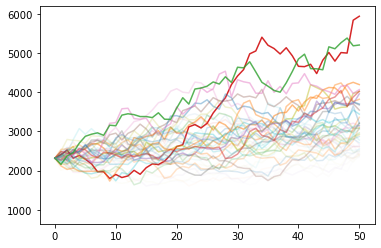

In [11]:
eur_call.plot_weighted_realizations(mkt, stock, n_steps = 50, MC_repetitions=100)

## 4. Volatility smile

Przy wycenie powstaje pytanie jak estymować zmienność cen akcji $\sigma$. Model BS zakłada, że ta zmienność jest stała dla konkretnej akcji, tzn. nie zmienia się w czasie i jest niezależna od parametrów wycenianej opcji. Łatwo jednak można się przekonać, że nie to mówi nam rynek.

Mówiąc dokładniej: nie znając nawet $\sigma$, i nie wiedząc które podejście do estymacji jest dobre, zawsze możemy obserwować rzeczywiste ceny opcji, którymi handluje się na rynku. Wszystkie parametry poza zmiennością mamy dostępne, więc możemy 'odwrócić' wzór Blacka-Scholesa żeby znaleźć $\sigma$ które implikuje rynek.

Charakterystycznym efektem który uzyskujemy jest tzw. *volatility smile/skew*, czyli zależność tej implikowanej zmienności od ceny wykonania opcji. Zazwyczaj minimum otrzymujemy w okolicach $K = S_0$, a im dalej od niej odejdziemy, tym zmienność implikowana jest wyższa (wygląda jak uśmiech, stąd nazwa). Spróbujemy numerycznie wyznaczyć implied volatility dla wybranych akcji.

Pozniżej: `BSPrice` wylicza cenę opcji z modelu Blacka-Scholesa w zależności od m.in. $\sigma$, a `BSsigma` odwraca zależność przy pomocy `scipy.optimize.fsolve`, żeby wyliczać $\sigma$ w zależności od ceny opcji.

In [12]:
# Calculate BS option price
def BSPrice(S0,K,r,sig,T, type_):
    
    d_plus = (np.log(S0/K)+(r+sig**2/2)*T)/(sig*np.sqrt(T))
    d_minus = d_plus - sig*np.sqrt(T)
    
    if type_ == 'Calls':
        price =  S0*norm.cdf(d_plus) - K*np.exp(-r*T)*norm.cdf(d_minus)
        
    elif type_ == 'Puts':
        price = K*np.exp(-r*T)*norm.cdf(-d_minus) - S0*norm.cdf(-d_plus)
    
    return(price)

# Calculate implied volatility
def BSsigma(S0,K,r,Price,T,type_, initial_guess=0.2):
    
    # dummy_fn has a root where some sigma satisfies the BS Pricing equation, for fixed Price
    dummy_fn = lambda sigma : BSPrice(S0=S0, K=K, r=r, sig=sigma, T=T, type_=type_) - Price 
    implied_vol = fsolve(dummy_fn, initial_guess) # find that sigma
    return implied_vol[0]

# wrapper for BSsigma, when input is a dataframe row
def calc_imp_vol(data_row, type_):
    years_to_expiry = (data_row['expiry'] - data_row['lastTradeDate']).days/365
    return BSsigma(data_row['St'], data_row['strike'], r, data_row['ask'], years_to_expiry, type_=type_ )

Serwis YahooFinance i biblioteka `yfinance` pozwalają zaciągać kwotowania opcji dla dostępnych w serwisie akcji: 
https://finance.yahoo.com/quote/MSFT/options?p=MSFT

Poniższa funkcja wybiera dane o konkretnym typie opcji (call lub put) na konkretny termin wykonania.

In [13]:
def get_option_table(ticker, expiry, type_):
    
    # obiekt do zaciagania danych
    stock = yf.Ticker(ticker)
    
    # historyczne ceny sie przydadza - bedziemy mieli opcje niekoniecznie kupione dzisiaj, (rozne S0)
    St = stock.history(period='max')[['Close']]
    St= St.reset_index()
    St = St.rename(columns={'Date':'lastTradeDate'})
    St['lastTradeDate'] = St['lastTradeDate'].apply(datetime.date)
    
    # tabela z opcjami na zadany expiry date
    if type_ =='Calls':
        opt_df = stock.option_chain(expiry).calls.dropna()
    elif type_ == 'Puts':
        opt_df = stock.option_chain(expiry).puts.dropna()
        
    # obróbka tabeli
    opt_df = opt_df[opt_df['impliedVolatility'] > 0.0001] # niehandlowane opcje == druga krzywa (historyczny trace) w implied volatility, wywalamy.
    opt_df = opt_df[['lastTradeDate','strike','ask','impliedVolatility']] # tylko istone kolumny
    opt_df['lastTradeDate'] = opt_df['lastTradeDate'].apply(datetime.date)
    opt_df = opt_df.merge(St, on='lastTradeDate', how='left') # dołączamy informację o cenie akcji as-of-trade date
    opt_df = opt_df.rename(columns={'Close':'St'})
    opt_df['expiry']= datetime.strptime(expiry, "%Y-%m-%d").date()
    
    return opt_df

get_option_table('MSFT', '2023-03-17', 'Puts')

,lastTradeDate,strike,ask,impliedVolatility,St,expiry
0,2021-05-28,110.0,2.37,0.399847,249.68,2023-03-17
1,2021-05-10,115.0,2.88,0.398321,246.61,2023-03-17
2,2021-05-03,120.0,3.25,0.390692,251.28,2023-03-17
3,2021-05-12,125.0,3.15,0.369208,238.45,2023-03-17
4,2021-05-17,130.0,5.40,0.406622,244.62,2023-03-17
5,2021-04-29,135.0,5.75,0.394751,251.93,2023-03-17
6,2021-05-28,140.0,4.50,0.349799,249.68,2023-03-17
7,2021-05-19,145.0,5.50,0.352942,243.12,2023-03-17
8,2021-05-20,150.0,5.50,0.335547,246.48,2023-03-17
9,2021-04-22,155.0,7.20,0.347998,256.58,2023-03-17


Powyższa tabela zawiera już zmienność implikowaną podawaną przez YahooFinance. Porównamy je przy okazji z naszymi wynikami. Poniżej wyliczamy zmiennosć implikowaną za pomocą `fsolve` i rysujemy jej zależność od ceny wykonania.

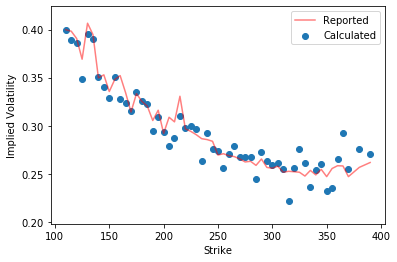

In [14]:
ticker = 'MSFT'
expiry = '2023-03-17'
r = mkt.fetch_r(expiry) # risk-free-rate
type_= 'Puts'

opt_df = get_option_table(ticker, expiry, type_ = type_)
opt_df['calc_imp_vol'] = opt_df.apply(calc_imp_vol,axis=1,type_=type_) # calculate implied volatility

plt.scatter(opt_df['strike'], opt_df['calc_imp_vol'], label = 'Calculated')
plt.plot(opt_df['strike'], opt_df['impliedVolatility'], color = 'red', alpha= 0.5, label='Reported')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
_=plt.legend()

## 5. Aplikacja w Dashu

Poniżej zbieramy powyższe funkcjonalności w jedną apkę 

In [15]:
# Inicjalizacja apki
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.LUX])
plotly_template = 'none'

# Grupa kontrolek z ustawieniami
controls = dbc.Card(
    [
        dbc.FormGroup(
            [dcc.Markdown("Ticker z [Yahoo Finance](https://finance.yahoo.com/) i okres do kalibracji:"),
             dcc.Input(
                 id="ticker_picker",
                 type='text',
                 placeholder="NFLX",
                 value = 'GOOG'),
             dcc.DatePickerRange(id='date_picker',
                                 max_date_allowed = datetime.today().date(),
                                 start_date = date(2020, 1, 1), end_date = date(2021, 1, 1),
                                 display_format = 'DD MMM, YYYY'),
             dbc.Button([dbc.Spinner(html.Div(id = "go_spinner"), size = 'sm')], id = "go_button", color = "primary")]),
        
        dbc.FormGroup(
            [dash_table.DataTable(
                id = 'GBM_estimates',
                columns=[{"name": i, "id": i} for i in ['S0', 'mu', 'sigma']],
                data=[{'S0':0, 'mu': 0, 'sigma': 0}])])
    ],
    body=True,
)

#Opis programu
Overview = dbc.Card(
    [
        dbc.FormGroup(
        [
            html.H6("Metoda Monte Carlo w wycenie wybranych typów opcji"),
            
            dcc.Markdown('''
            * Program zaciąga dane rynkowe z serwisu Yahoo Finance. Przy założeniu, że za danymi stoi Geometryczny Ruch Browna estymowane są jego parametry: dryfu i dyfuzji.
            * Na podstawie wyestymowanych parametrów symulowane są inne realizacje GBM, które służą do wyceny popularnych rodzajów opcji. Na wykresie realizacji GBM widać jakie trajektorie miały największą wagę przy wycenie (twardość kreski dla trajektorii jest proporcjonalna do wielkości wypłaty)
            * W dolnym panelu, z realnych cen opcji obserwowanych na rynku wyznaczana jest implikowana zmienność. Obserwować można jej zależność od ceny wykonania (tzw. volatility smile).
            
            ''')
        ])
    ],
    body=True
)

# Zmienność implikowana
Imp_Vol_Card = dbc.Card(
[dbc.Row([
    dbc.Col([
        html.H4("Tabela opcji:"),

        dbc.Row([dbc.Col(dcc.Dropdown(id='option_type_picker',
                                      options=[{'label': x, 'value': x} for x in ['Calls','Puts']],
                                      value='Calls',
                                      multi=False)),
                 
                 dbc.Col(dcc.Dropdown(id='expiry_picker',
                                      options=[{'label': x, 'value': x} for x in ['2023-01-20']],
                                      value='2023-01-20',
                                      multi=False)),
                 
                 dbc.Col(dbc.Button("Check",
                                    id="optionTable_button",
                                    color="primary"))]),
            
        dash_table.DataTable(id='option_table', 
                             style_table={'overflowY': 'scroll',
                                          'height': 350})]),
    
    dbc.Col([dcc.Graph(id="imp_vol_chart")])])], body = True)



#Pricing opcji
Pricing_Menu_Card = dbc.Card(
    [dbc.Row([dbc.Col([html.H4("Wycena Monte Carlo:"),
                       dcc.Dropdown(id = 'MC_option_type_picker',
                                    options = [{'label':opt.name, 'value':opt.name} for opt in option_list],
                                    value = eur_call.name,
                                    multi = False),
                       dbc.Row([
                           dbc.Col([
                               dcc.Input(id="MC_samples",
                                         type='number',
                                         placeholder="e.g. 10000",
                                         value = 1000),
                               dcc.Markdown("MC samples")]),
                           dbc.Col([
                               dcc.Input(id="Path_steps",
                                         type='number',
                                         placeholder="e.g. 50",
                                         value = 50),
                               dcc.Markdown("Path steps")]),
                           dbc.Col([
                               dcc.Input(id="Epsilon",
                                         type='number',
                                         placeholder="e.g. 0.0001",
                                         value = 0.0001),
                               dcc.Markdown("Epsilon (for Delta est.)")])]),
                       dbc.Row([
                           dbc.Col([
                               dcc.Input(id="Opt_Strike",
                                         type='number',
                                         placeholder="e.g. 2500",
                                         value = 2500),
                               dcc.Markdown("Strike")]),
                           dbc.Col([
                               dcc.Input(id="Opt_Expiry",
                                         type='number',
                                         placeholder="e.g. 1",
                                         value = 1),
                               dcc.Markdown("Years to expiry")]),
                           dbc.Col([
                               dcc.Input(id="Opt_Barrier",
                                         type='number',
                                         placeholder="e.g. 4000",
                                         value = 4000),
                               dcc.Markdown("Barrier (for barrier options)")])]),
                       dbc.Card([
                               dbc.Col([
                                   dbc.Row(dcc.Checklist(id = "Override_Switch",
                                                         options=[{'label': ' Override stock parameters:', 'value': 1}]))]),
                               dbc.Col([
                                   dbc.Row([dcc.Input(id = "Override_S0",
                                                     type = "number",
                                                     placeholder="e.g. 100"), dcc.Markdown("(S0)")]),
                                   dbc.Row([dcc.Input(id = "Override_sigma",
                                                     type = "number",
                                                     placeholder="e.g. 0.4"), dcc.Markdown("(sigma)")]),
                                   dbc.Row([dcc.Input(id = "Override_r",
                                                     type = "number",
                                                     placeholder="e.g. 0.04"), dcc.Markdown("(r)")])])])]),
              dbc.Col([dash_table.DataTable(id = 'Pricing_results',
                                            columns=[{"name": i, "id": i} for i in ['Price', '(Price SE)', 'Delta', '(Delta SE)']],
                                            data=[{'Price':0, '(Price SE)': 0, 'Delta': 0, '(Delta SE)':0}]),
                       dcc.Graph(id= 'weighted_realizations_chart')])])],body = True)

# Layout całej apki
app.layout = dbc.Container(
    [
        html.Br(),
        html.H1("Model Blacka-Scholesa"),
        html.Hr(),

        dbc.Row([
            #Col1
            dbc.Col([                
                html.H3("Ustawienia programu:"),
                controls,
                               
                html.Br(),
                html.Br(),
                
                Overview],
            md=4),

            #Col2
            dbc.Col(dbc.Row([Pricing_Menu_Card,
                             Imp_Vol_Card]))])],
        fluid=False)

app.layout = dbc.Container(
    [
        html.Br(),
        html.H1("Model Blacka-Scholesa"),
        html.Hr(),

        dbc.Row([
            dbc.Col([html.H3("Ustawienia programu:"),
                     controls]),
            dbc.Col([Overview])]),
        dbc.Row([Pricing_Menu_Card]),
        dbc.Row([Imp_Vol_Card])],fluid=False)


# Callback do zaciągania danych kalibracji GBM
@app.callback(
    [Output("go_spinner", "children"),
     Output("GBM_estimates", "data"),
     Output("expiry_picker", "options"),
     Output("weighted_realizations_chart", "figure"),
     Output("Pricing_results", "data")],
    Input("go_button", "n_clicks"),
    [State('ticker_picker', 'value'),
     State('date_picker', 'start_date'),
     State('date_picker', 'end_date'),
     State('MC_samples', 'value'),
     State('Path_steps', 'value'),
     State('Epsilon', 'value'),
     State('Opt_Strike', 'value'),
     State('Opt_Expiry', 'value'),
     State('Opt_Barrier', 'value'),
     State('Override_Switch', 'value'),
     State('Override_S0', 'value'),
     State('Override_sigma', 'value'),
     State('Override_r', 'value'),
     State('MC_option_type_picker','value')])  
def main_fcn(n_clicks, yf_ticker, start_date, end_date,
             iMC_samples, iPath_steps, fEpsilon,
             fStrike, fExpiry, fBarrier,
             bOverride, fOverrideS0, fOverrideSigma, fOverrideR,
             sOption_Type):
    
    # Zaciąganie danych
    df = yf.download(yf_ticker, start_date, end_date)['Adj Close']
    df.name = yf_ticker
    stock = Stock(df)    
    mkt = Market()
    yfObject = yf.Ticker(yf_ticker)
    all_expiries = [{'label': x, 'value': x} for x in yfObject.options]
    gbm_estimates = [{'S0': stock.S0.round(2), 'mu': stock.mu.round(4), 'sigma': stock.sigma.round(4)}]
    option = option_dict[sOption_Type]
    option.K = fStrike
    option.T = fExpiry
    option.B = fBarrier
    
    overrides = {'S0': fOverrideS0,
                'sigma': fOverrideSigma,
                'r': fOverrideR}
    
    if bOverride is not None:
        bOverride = len(bOverride)>0
    else:
        bOverride = False
    
    # Inicjalizuj z oryginalnymi parametrami
    params = {'S0': stock.S0,
              'r' : mkt.fetch_r(option.ExpiryDate()),
              'sigma' : stock.sigma}
        
    # Nadpisz wybrane z nich
    if bOverride:
        for ov in overrides: 
            if overrides[ov] is not None:
                params[ov] = overrides[ov]    
    
    option.PriceByMC(mkt, stock,
                     n_steps = iPath_steps , MC_repetitions = iMC_samples,
                     antithetic = True, epsilon = fEpsilon,
                     overrides = params)
    
    pricingResults = [{'Price': option.Price.round(6),
                       '(Price SE)': option.Price_se.round(6),
                       'Delta': option.Delta.round(6),
                       '(Delta SE)': option.Delta_se.round(6)}]
    
    weighted_realizations_chart = plot_weighted_realizations(option, params = params,
                                                             n_steps = iPath_steps, MC_repetitions = iMC_samples)
    
    return "Update!", gbm_estimates, all_expiries, weighted_realizations_chart, pricingResults

@app.callback(
    [Output("option_table","data"),
     Output("option_table","columns"),
     Output("imp_vol_chart","figure")],
    Input("optionTable_button","n_clicks"),
    [State('ticker_picker','value'),
     State('option_type_picker','value'),
     State('expiry_picker','value')])
def load_option_table(n_clicks, ticker, type_, expiry):
    
    opt_df = get_option_table(ticker = ticker, expiry = expiry, type_ = type_)
    
    opt_df['Calculated_imp_vol'] = opt_df.apply(calc_imp_vol, axis = 1, type_ = type_) # calculate implied volatility
    opt_df = opt_df.drop(['r'], axis=1)
    data=opt_df.round({'Calculated_imp_vol': 4, 'Imp_Vol': 4}).to_dict(orient = 'records')
    columns = [{"name": i, "id": i} for i in opt_df.columns]
    
    imp_vol_plot = plot_implied_vol(opt_df, 0.2)
    return data, columns, imp_vol_plot

def plot_implied_vol(opt_df, sigma_est):
        
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x = opt_df["Strike"],
                             y = opt_df["Imp_Vol"],
                             mode = 'lines',
                             name = 'Reported'))
    
    fig.add_trace(go.Scatter(x = opt_df['Strike'],
                             y = opt_df['Calculated_imp_vol'],
                             mode = 'markers',
                             name = 'Calculated'))
    
    fig.update_layout(title = "Zmienność implikowana",
                      xaxis_title = "Strike",
                      yaxis_title = "Volatility")

    return fig

def plot_weighted_realizations(option, params,
                               n_steps= 50, MC_repetitions= 1000):
        
        # Symuluj GBM
        paths = generateGBM(S0 = params['S0'],
                    mu = params['r'],
                    sigma = params['sigma'],
                    T = option.T,
                    n_steps = n_steps,
                    n_paths = MC_repetitions,
                    antithetic = False,
                    plot_ = False)
        
        # Licz wypłatę
        H = option.Payoff(paths, option.K, option.B)
        
        # Wagi na [0,1], do cieniowania trajektorii na wykresie:
        # (większy payoff -> większa waga)
        if H.max()!=0:
            w = H/H[0:min(999,len(H)-1)].max() # będziemy rysować max 1000 trajektorii
        else:
            w = H*0
        
        # Rysuj trajektorie:
        fig = go.Figure()
        
        for i, a in enumerate(w):
            if i>=1000:
                break
                
            fig.add_trace(go.Scatter(x = np.arange(0,len(paths[:,i]),1),
                                     y = paths[:,i],
                                     mode = 'lines',
                                     opacity = a))
        fig.update_layout(showlegend=False)
        
        return fig

def get_option_table(ticker, expiry, type_):
    
    # obiekt do zaciagania danych
    stock = yf.Ticker(ticker)
    
    # historyczne ceny sie przydadza - bedziemy mieli opcje niekoniecznie kupione dzisiaj, (rozne S0)
    So = stock.history(period = '1d')['Close'][0]
    
    # tabela z opcjami na zadany expiry date
    if type_ == 'Calls':
        opt_df = stock.option_chain(expiry).calls.dropna()
    elif type_ == 'Puts':
        opt_df = stock.option_chain(expiry).puts.dropna()
        
    # obróbka tabeli
    opt_df = opt_df[opt_df['impliedVolatility'] > 0.0001] # niehandlowane opcje wywalamy
    opt_df = opt_df[['lastTradeDate', 'strike', 'ask', 'impliedVolatility']] # tylko istone kolumny
    opt_df['lastTradeDate'] = opt_df['lastTradeDate'].apply(datetime.date)
    opt_df['Close'] = So
    opt_df = opt_df.rename(columns={'Close':'So', 'lastTradeDate':'Last_Trade',
                                    'strike':'Strike', 'ask':'Ask',
                                    'impliedVolatility':'Imp_Vol'})
    opt_df['expiry']= datetime.strptime(expiry, "%Y-%m-%d").date()
    opt_df['r'] = Market().fetch_r(expiry)  # żeby mieć r(t)
    
    return opt_df

# Oblicz cenę z MBS
def BSPrice(S0,K,r,sig,T, type_):
    
    d_plus = (np.log(S0/K)+(r+sig**2/2)*T)/(sig*np.sqrt(T))
    d_minus = d_plus - sig*np.sqrt(T)
    
    if type_ == 'Calls':
        price =  S0*norm.cdf(d_plus) - K*np.exp(-r*T)*norm.cdf(d_minus)
        
    elif type_ =='Puts':
        price = K*np.exp(-r*T)*norm.cdf(-d_minus) - S0*norm.cdf(-d_plus)
    
    return(price)

# Calculate implied volatility
def BSsigma(S0,K,r,Price,T,type_, initial_guess=0.2):
    
    # dummy_fn has a root where some sigma satisfies the BS Pricing equation, for fixed Price
    dummy_fn = lambda sigma : BSPrice(S0=S0, K=K, r=r, sig=sigma, T=T, type_=type_) - Price 
    implied_vol = fsolve(dummy_fn, initial_guess) # find that sigma
    return implied_vol[0]
    
    implied_vol = fsolve(dummy_fn, initial_guess)  # znajdź tę sigmę
    return implied_vol[0] if implied_vol[0] != initial_guess else np.nan  # jak się nie uda, to zwróć NaN

def calc_imp_vol(data_row, type_):
    # wrapper for implied volatility calculation
    
    years_to_expiry = (data_row['expiry'] - datetime.today().date()).days/366
    return BSsigma(data_row['So'], data_row['Strike'], data_row['r'], data_row['Ask'], years_to_expiry, type_ = type_)


app.run_server(mode='external')

Dash app running on http://127.0.0.1:8050/
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
